In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
# Pkg.add("ForwardDiff")
# Pkg.add("RobotDynamics")
# Pkg.add("LinearAlgebra")
# Pkg.add("StaticArrays")
# Pkg.add("SparseArrays")
# Pkg.add("Plots")
# Pkg.add("Printf")
# Pkg.add("Ipopt")
# Pkg.add("MathOptInterface")
# Pkg.add("TrajOptPlots")
using ForwardDiff
using Test
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
using Ipopt
using MathOptInterface
using TrajOptPlots
const MOI = MathOptInterface
# Pkg.add("Multi-Threading")
# using Multi-Threading
# using PyPlots
using Printf

# include("quadratic_cost.jl")


# Final Project Info
In this we present a geostationary transfer orbit to a geosynchronous (GSO) or geostationary orbit (GEO).  We use Keplerian Orbital Dynamics to model our system. We make several assumptions like Earth Reference Frame, Spherical Earth, Kepler Dynamics. 

## The Model
We'll be using the Kepler Dynamics:

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$$ 
\ddot{r} = F = \frac{-\mu}{\norm{r}^3}*r+u \\
x = [r, \dot{r}] \\
\norm{u} \le Tmax
$$
with the following model parameters:
* $\mu$: Gravitational Parameter = 63781
* $r$: distance to earth center
* $u$: control of ion thruster

In [3]:
Threads.nthreads()

20

In [4]:
# Problem Setup
# Dont want KM and S
# Rescale unite to order 1
# Length unit = SMA 
# Time scale = T orbit period
# Helps condition number 

Nx = 6 
Nu = 3

# Hint can take big steps 10 knot points per-orbit
# model = Kepler() # TODO
# n,m = size(model)          # state and control dimensions
# TODO FIX ME
dt = 0.025                 # time step (sec)
tf = 1.5                   # time horizon (sec)
T = Int(tf/dt) + 1         # number of time steps

# n_nlp = (Nx+Nu)*T # number of decision variables
# m_nlp = Nx*(T+1)

# Initial & final condition

#cartesian and ECI
#x,y,z,vx,vy,vz
earthRadius_km = 6378.1 # [km]
LEO_km = 500 #km above sealevel #circular low earth orbit # 250km 
GSO_km = 35786 #km above sealevel #circular geosychonous orbit
μ_km_s = 3.986*10e5 #gravitational0 parameter [km^3 / s^2]
semiMajorAxis_scale = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/2
period_scale = sqrt(semiMajorAxis_scale^3/μ_km_s)*2*pi
μ = μ_km_s*period_scale^2/semiMajorAxis_scale^3  #μ(OU^3/P^2)

struct Orbit{T}
    semiMajorAxis::T
    period::T
    perigee::T #closest radius to earth
    perigee_V::T #velocity at perigee
    x0::Vector{T}
#     function Orbit(x0) 
#         print(x0) #best is to input point with velocity and calucate useful parts of orbit
#     end
end

function make_orbit(x0)
    velocity = norm(x0[4:end])
    
    radius = norm(x0[1:3])
    
    semiMajorAxis = 1/(-velocity^2/μ+2/radius)  #reverse vis a viv
    
    period = sqrt(semiMajorAxis^3/μ)*2*pi       #period equation
    
    E = velocity^2/2 - μ/radius   #specific energy of satellite
    
    J = norm(cross(x0[1:3],x0[4:end]))           #specific momentum of satellite
    
    perigee = -μ/(2*E) - 1/2*sqrt(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    
    perigee_v =  sqrt(μ*(2.0/perigee-1.0/semiMajorAxis)) # Vis a Viv
    apogee  = -μ/(2*E) + 1/2(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    apogee_v =  sqrt(μ*(2.0/apogee-1.0/semiMajorAxis)) # Vis a Viv
    return Orbit(semiMajorAxis, period, perigee, perigee_v, x0)
end

make_orbit (generic function with 1 method)

In [5]:
# Geosynchronous Transfer orbit (starting position)
semiMajorAxis_transfer = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/(2*semiMajorAxis_scale) #OU
instantRadius_transfer = (earthRadius_km+LEO_km) / semiMajorAxis_scale # #OU
instantVelocity_transfer = sqrt(μ*(2.0/instantRadius_transfer-1.0/semiMajorAxis_transfer)) #sqrt(OU^3/P^2/OU) =OU/P
period_transfer = sqrt(semiMajorAxis_transfer^3/μ)*2*pi
x0    = [instantRadius_transfer, 0.0, 0.0, 0.0, instantVelocity_transfer, 0.0] # initial state #geosynchronous transfer orbit (GTO, where rocket dropped satellite off)
                                                                             #many kilometers above Africa in an elliptical orbit 
transfer_orbit = Orbit(semiMajorAxis_transfer, period_transfer, instantRadius_transfer, instantVelocity_transfer, x0)

Orbit{Float64}(1.0, 1.0, 0.28049720444841386, 15.556684458046954, [0.28049720444841386, 0.0, 0.0, 0.0, 15.556684458046954, 0.0])

In [6]:
# Geosynchronous Orbit (goal position)
semiMajorAxis_goal = 2*(earthRadius_km+GSO_km)/(2*semiMajorAxis_scale)
instantRadius_goal = (earthRadius_km+GSO_km) / semiMajorAxis_scale
instantVelocity_goal = sqrt(μ*(2.0/instantRadius_goal-1.0/semiMajorAxis_goal)) # VisViva
period_goal = sqrt(semiMajorAxis_goal^3/μ)*2*pi
xgoal = [instantRadius_goal, 0.0, 0.0, 0.0, instantVelocity_goal, 0.0] # goal state #circular geosychonous orbit above africa
goal_orbit = Orbit(semiMajorAxis_goal, period_goal, instantRadius_goal, instantVelocity_goal, xgoal)
ugto = zeros(3)                  # hover controls


3-element Vector{Float64}:
 0.0
 0.0
 0.0

## Cost Function

In [7]:
function cost(prob, Z)
    X, U = unpackZ(prob.N, Z)
   # U = Z[Nx+1:Nx+Nu, :]
    N = prob.N
    J = 0.0
    for k = 1:N-1
        J += norm(U[:, k])^2 + (norm(X[1:3, k])-goal_orbit.perigee)
    end 
    J += (norm(X[:,end]-xgoal))
    return J 
end

cost (generic function with 1 method)

## Dynamics

In [8]:
function dynamics(x, u)
    # x = state [x, y, z, dx, dy, dz]
    # u = control [ux, uy, uz]
    r = x[1:3] #orbital units (OU)
    ṙ = x[4:end] #
    r̈ = (-μ/(norm(r)^3))*r + u #μ(OU^3/P^2)/OU^3*OU
    return [ṙ; r̈]
end

dynamics (generic function with 1 method)

In [9]:
function integrator!(x, u, h)
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    x .+= (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

integrator! (generic function with 1 method)

In [10]:
function dynamics_rk4(x, u, h) # Maybe rk8 or more
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    return (x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
end

dynamics_rk4 (generic function with 1 method)

In [11]:
function get_energy(x)
    return norm(x[4:end])^2/2 - μ/norm(x[1:3])
end

get_energy (generic function with 1 method)

In [12]:
knots = 100
function plot_orbit(orbit::Orbit)
    t = range(0, orbit.period, length=knots) 
    h = t[2]-t[1]
    traj = zeros(size(t)[1], size(x0)[1])
    x = copy(orbit.x0)
    traj[1,:] .= x
    
    u = zeros(3)
    energy = zero(t)
    energy[1] = get_energy(x)
    for i in 2:size(t)[1]
        integrator!(x, u, h)
        traj[i,:] .= x
        energy[i] = get_energy(x)
        orbit = make_orbit(x)
    end
#     plot(t, energy)
    plot(traj[:, 1], traj[:, 2], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5))
end

plot_orbit (generic function with 1 method)

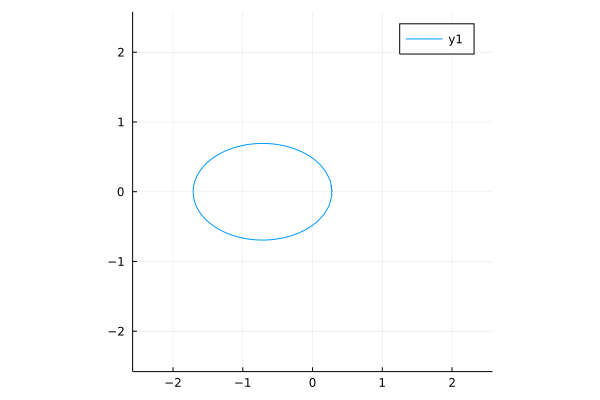

In [13]:
# plot(t, energy)
plot_orbit(transfer_orbit)

## Constraints

$ c = [c_{init}, c_{terminal}, c_{dynamics}, c_{thurst}] $

In [14]:
function unpackZ(N, ztraj)
    """
    Inputs: 
        ztraj -> Trajectory
    
    Returns: 
        xtraj -> state trajectory (Nx, T)
        utraj -> control trajectory (Nu, T-1)
    """
    Nt = N
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = hcat(z[1:Nx,:], ztraj[end-(Nx-1):end])
    utraj = z[(Nx+1):(Nx+Nu),:]
    
    return xtraj, utraj
end

unpackZ (generic function with 1 method)

In [15]:
function dynamics_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """
    h = nlp.h # dt? 
    X, U = unpackZ(nlp.N, ztraj)
    N = nlp.N

    d = reshape(view(c, nlp.idx_ineq[3]), Nx,(N-1))
    
    for k = 1:N-1
        d[:, k] .= dynamics_rk4(X[:,k], U[:,k], h) - X[:,k+1]
    end
    
    return d
end
    

dynamics_constraints! (generic function with 1 method)

In [16]:
function thrust_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """
    N = nlp.N
    d = reshape(view(c, nlp.idx_ineq[4]), Nu,(N-1))#view(c, nlp.idx_ineq[end])#
    X, U = unpackZ(nlp.N, ztraj)
    
    for k = 1:N-1
        d[:,k] .= norm(U[:,k])
    end
    
    return d
end

thrust_constraints! (generic function with 1 method)

In [17]:
function con!(nlp, c, Z)
    X, U = unpackZ(nlp.N, Z)
    c[nlp.idx_ineq[1]] .= X[:,1] - x0 # Initial condition constraint
    c[nlp.idx_ineq[2]] .= X[:,end] - xgoal # Final condition constraint
    dynamics_constraints!(nlp, c, Z) # Dynamics constraints
    thrust_constraints!(nlp, c, Z) # Thrust constraints
end

con! (generic function with 1 method)

## Part (a): Implement DIRCOL 
Implement DIRCOL by completing the provided methods. 

In [29]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""
# struct Problem{n,m,L}
    # TODO 
# end
# Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int # num_primals
    m_nlp::Int # num_duals
    N::Int # num_knots
    h::Float64
    idx_ineq # list of constraint ranges
    obj_grad::Bool 
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp, N, h;
        idx_ineq=get_cinds(Nx, N),
        m_nlp = idx_ineq[end][end],
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(
        n_nlp,
        m_nlp,
        N, # Nt
        h, 
        idx_ineq, # Indexes
        obj_grad, 
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function get_cinds(n, N)
    c_init_inds = 1:Nx
    c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+Nx)
    c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+((Nx)*(N-1)))
    c_thrust_inds = (c_dyn_inds[end]+1):(c_dyn_inds[end]+(Nu*(N-1)))
    
    return [c_init_inds, c_term_inds, c_dyn_inds, c_thrust_inds]
end

function constraint_bounds(m_nlp; idx_ineq)
    lb = zeros(m_nlp) 
    lb[idx_ineq[1]] .= 0 ##x0
    lb[idx_ineq[2]] .= 0 #xf
    lb[idx_ineq[3]] .= 0
    lb[idx_ineq[4]] .= 0 # Might have a minimum thrust requirment

    ub = zeros(m_nlp) #fill(-Inf,m_nlp)
    ub[idx_ineq[1]] .= 0 #x0
    ub[idx_ineq[2]] .= 0 #xf
    ub[idx_ineq[3]] .= 0
    ub[idx_ineq[4]] .= Inf

    return lb, ub
end

function row_col!(row,col,r,c)
    println("starting row_col")
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    println("Finished row_col")
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(prob, x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f, x -> cost(prob, x), x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(prob, g, x) # TODO: Implement con! (Mitch)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), (c,x) -> con!(prob, c, x), zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

# TODO: Confirm meaning of these functions
MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac #



function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=1000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver, prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

0.01

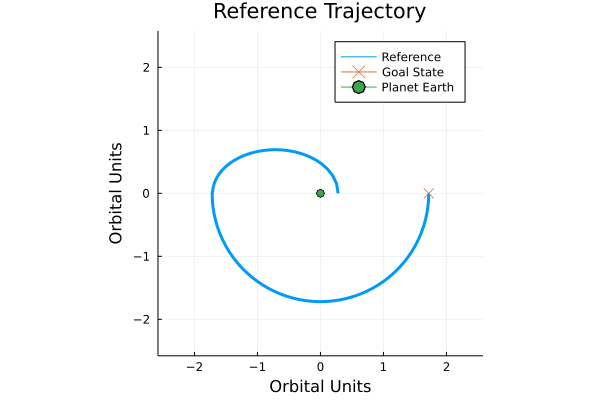

In [30]:
knots = 100
# t = range(0, orbit.period, length=knots) 
# h = t[2]-t[1]
function impulse_ref_traj(init_orbit::Orbit,final_orbit::Orbit) #knots,Nx,Nu
    time = knots #Int(ceil(init_orbit.period/2*knots/2+final_orbit.period*knots))
    traj = zeros(time-1,Nx+Nu)
    x = copy(init_orbit.x0)
    u = zeros(Nu)
    traj[1,:] .= vcat(x,u)
    h = init_orbit.period/(knots)
    print(h)
    for i in 2:size(traj)[1]
        integrator!(x, u, h)
        if (i == Int(ceil(init_orbit.period/2*knots)))
            x = final_orbit.x0 .* -1
            h = final_orbit.period/(knots)
        end
        traj[i,:] .= vcat(x,u)
    end
    traj = reshape(traj',((time-1)*(Nx+Nu),1))
    traj = vcat(traj,final_orbit.x0)
    return traj
end
z = impulse_ref_traj(transfer_orbit,goal_orbit)
X,U = unpackZ(knots, z)
transition = Int(ceil(transfer_orbit.period*knots/2))
# display(X[:,transition-5:transition+5]')
plot(X[1, :], X[2, :], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5), title = "Reference Trajectory", label = "Reference", lw = 3)
xlabel!("Orbital Units")
ylabel!("Orbital Units")
plot!([goal_orbit.x0[1]], [goal_orbit.x0[2]], markershape=:xcross, markersize=5, label="Goal State")
plot!([0], [0], lw=10, markershape=:o, label="Planet Earth")

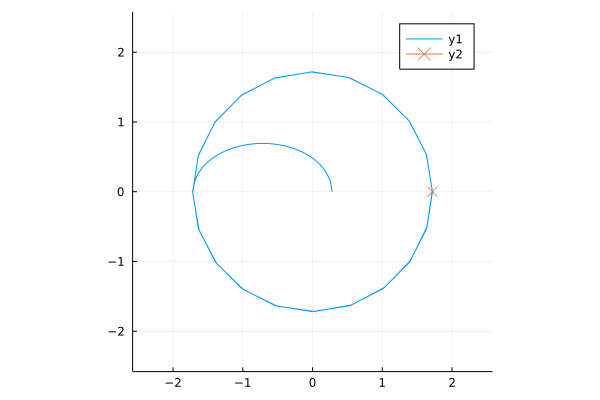

In [31]:
knots = 100
function impulse_ref_traj(init_orbit::Orbit,final_orbit::Orbit) #knots,Nx,Nu
    time = knots #Int(ceil(init_orbit.period/2*knots/2+final_orbit.period*knots))
    traj = zeros(time-1,Nx+Nu)
    x = copy(init_orbit.x0)
    u = zeros(Nu)
    traj[1,:] .= vcat(x,u)
    h = init_orbit.period/(knots)
    for i in 2:size(traj)[1]
        integrator!(x, u, h)
        if (i == Int(ceil(init_orbit.period/2*knots)))
            x = final_orbit.x0 .* -1
            h = 5*final_orbit.period/(knots)
        end
        traj[i,:] .= vcat(x,u)
    end
    traj = reshape(traj',((time-1)*(Nx+Nu),1))
    traj = vcat(traj,final_orbit.x0)
    return traj
end
z = impulse_ref_traj(transfer_orbit,goal_orbit)
X,U = unpackZ(knots, z)
transition = Int(ceil(transfer_orbit.period*knots/5))
# display(X[:,transition-5:transition+5]')
plot(X[1, :], X[2, :], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5))
plot!([goal_orbit.x0[1]], [goal_orbit.x0[2]], markershape=:xcross, markersize=5)

In [32]:
# @userplot CirclePlot
# @recipe function f(cp::CirclePlot)
#     x, y, i = cp.args
#     n = length(x)
#     inds = circshift(1:n, 1 - i)
#     linewidth --> range(0, 10, length = n)
#     seriesalpha --> range(0, 1, length = n)
#     aspect_ratio --> 1
#     label --> false
#     x[inds], y[inds]
# end

# n = 150
# t = range(0, 2π, length = n)
# x =  #sin.(t)
# y = cos.(t)

# anim = @animate for i ∈ 1:n
#     circleplot(x, y, i)
# end
# gif(anim, "anim_fps15.gif", fps = 15)

In [33]:
# knots_final = 10000
# X = zeros((Nx, knots_final))
# X[:, 1] .= transfer_orbit.x0
# for k = 1:knots_final-1
#     X[:, k+1] = dynamics_rk4(X[:, k], zeros(3), 1e-3)
# end

┌ Info: Saved animation to 
│   fn = /home/aipex/Mitch/16-745_final_project/tmp.gif
└ @ Plots /home/aipex/.julia/packages/Plots/lzHOt/src/animation.jl:104


Plots.AnimatedGif("/home/aipex/Mitch/16-745_final_project/tmp.gif")
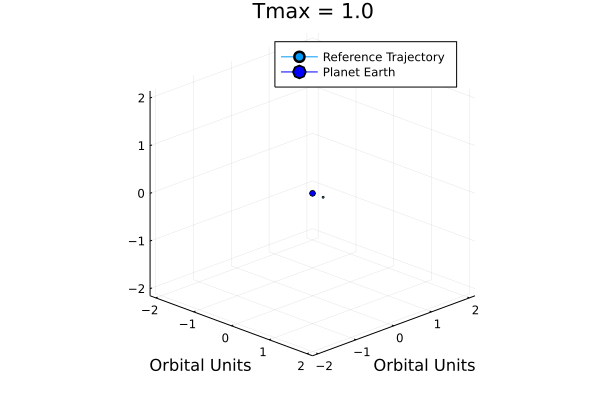

In [102]:
using Plots
# define the Lorenz attractor
Base.@kwdef mutable struct Trajectory
#     dt::Float64 = 0.02
#     σ::Float64 = 10
#     ρ::Float64 = 28
#     β::Float64 = 8/3
    x::Float64 = Xsol[1,1]
    y::Float64 = Xsol[2,1]
    z::Float64 = Xsol[3,1]
    ux::Float64 = Usol[1,1]
    uy::Float64 = Usol[2,1]
    uz::Float64 = Usol[3,1]
    i::Int = 0
end

function step!(l::Trajectory)
    l.i += 1
    l.x = Xsol[1, l.i]
    l.y = Xsol[2, l.i]
    l.z = Xsol[3, l.i]
#     l.ux = U[1, l.i]
#     l.uy = U[2, l.i]
#     l.uz = U[3, l.i]
    
#    
end

t = Trajectory()


# initialize a 3D plot with 1 empty series
plt = plot3d(
    1,
    lims=(-semiMajorAxis_goal*1.25,semiMajorAxis_goal*1.25),
#     xlim = (-30, 30),
#     ylim = (-30, 30),
#     zlim = (0, 60),
    title = "Tmax = 1.0",
    marker = 2,
    label = "Reference Trajectory", 
    camera = (45, 45), 
    aspect_ratio=:equal,
)
plot!([0], [0], [0], markershape=:o, markersize=3, label="Planet Earth", color=:blue)
xlabel!("Orbital Units")
ylabel!("Orbital Units")
# label!("Orbital Units")
# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for i=1:knots
    step!(t)
    push!(plt, t.x, t.y, t.z)

end every 10

In [34]:
n_nlp = (Nx+Nu)*(knots-1)+Nx # number of decision variables
idx = get_cinds(Nx, knots)
m_nlp = idx[end][end]
h = 1/knots #transfer_orbit.period*5/knots

0.01

In [35]:
sj = sparsity_jacobian(n_nlp, m_nlp)
sh = sparsity_hessian(n_nlp, m_nlp)

# TODO: Visualize results

starting row_col
Finished row_col
starting row_col
Finished row_col


809991-element Vector{Tuple{Any, Any}}:
 (1, 1)
 (2, 1)
 (3, 1)
 (4, 1)
 (5, 1)
 (6, 1)
 (7, 1)
 (8, 1)
 (9, 1)
 (10, 1)
 (11, 1)
 (12, 1)
 (13, 1)
 ⋮
 (892, 897)
 (893, 897)
 (894, 897)
 (895, 897)
 (896, 897)
 (897, 897)
 (898, 897)
 (899, 897)
 (900, 897)
 (901, 897)
 (902, 897)
 (903, 897)

In [36]:
prob = ProblemMOI(n_nlp, knots, h, m_nlp=m_nlp, idx_ineq=idx, sparsity_jac=sj, sparsity_hess=sh)
z_sol = solve(z,prob) # solve

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   543582
Number of nonzeros in inequality constraint Jacobian.:   266409
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      897
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:      297
        inequality constraints with only lower bounds:      297
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

897-element Vector{Float64}:
    0.28049720444841386
    9.442671443702965e-28
   -5.114346618673303e-35
   -4.943802405861555e-27
   15.556684458046954
    0.0
    2.93890427331215
    9.948870436497721
   -3.443762859233867e-7
    0.2566912645874043
    0.1516289486147049
   -1.6958410075827994e-11
   -4.56349755928235
    ⋮
    4.421533508795991
    3.5522302194141964
   -2.513573561558946e-8
 -428.6893914263729
  123.7615083860375
    2.513908336304302e-6
    1.7195027955515862
    0.0
    0.0
    0.0
    4.791576488602332
    0.0

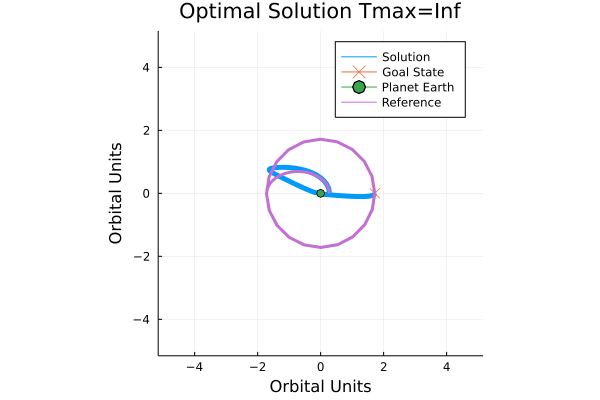

In [41]:
Xsol,Usol = unpackZ(knots, z_sol)
plot(Xsol[1, :], Xsol[2, :], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*3,semiMajorAxis_goal*3), label="Solution", lw=5)
xlabel!("Orbital Units")
ylabel!("Orbital Units")
plot!([goal_orbit.x0[1]], [goal_orbit.x0[2]], markershape=:xcross, markersize=5, label="Goal State")
plot!([0], [0], lw=1, markershape=:o, label="Planet Earth")
plot!(X[1, :], X[2, :], title = "Optimal Solution Tmax=Inf", label = "Reference", lw = 3)


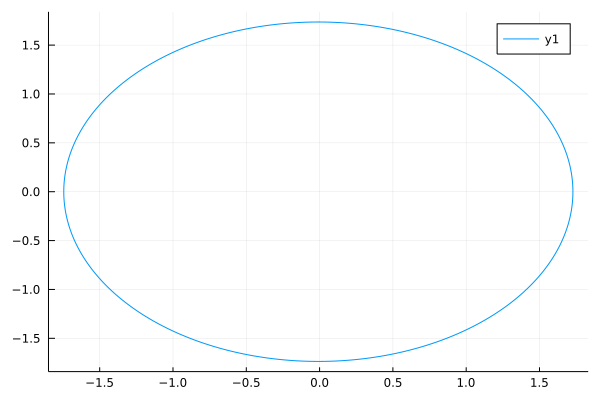

In [75]:
knots_final = 10000
Xfinal = zeros((Nx, knots_final))
Xfinal[:, 1] .= Xsol[:,end]
for k = 1:knots_final-1
    Xfinal[:, k+1] = dynamics_rk4(Xfinal[:, k], zeros(3), 1e-2)
end
plot(Xfinal[1,:], Xfinal[2,:], )

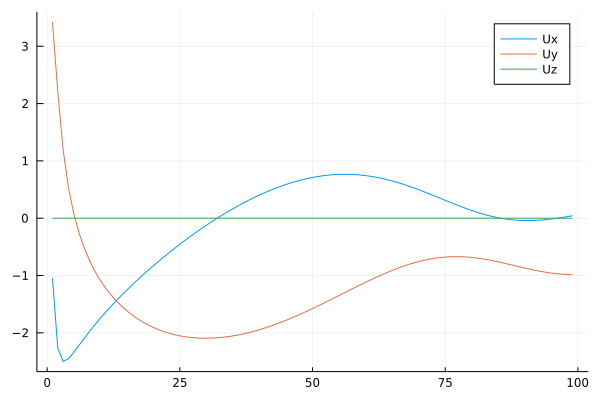

In [101]:
plot(1:knots-1, Usol[1, :], label="Ux")
plot!(1:knots-1, Usol[2, :], label="Uy")
plot!(1:knots-1, Usol[3, :], label="Uz")

# DIRCOL Algorithm

In [ ]:
# TASK: Complete implement DIRCOL Algo



### Forward Pass

In [ ]:
# TASK: Complete forward simulation of satelite 

## Part (b): Simple trajectory 
Planar example with quibit interpolation and no Thurst conditions

In [ ]:
# Task Solve Simple Trajectory

In [ ]:
# vis = Visualizer()
# set_mesh!(vis, model)
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xline)

## Part (c): Higher Order DIRCOL
Solve the simple planar problem with unconstrained thrust with higher order DIRCOL 3->8th order

In [ ]:
# TASK: Implement the following method

In [ ]:
# TASK: Plot the comparison


## Part (d): Inequality Constraints 
Using the thruster constraints solve the optimization problem

In [ ]:
# TASK: Inequality constraints

In [ ]:
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xflip)

## Part (e): Non-Planar Satellite Control


In [ ]:
# TASK: Non-Planar Control

## TESTS

In [ ]:
# run_tests();